<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/HI_MAP_MATxSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages(c('raster','sf','data.table','magrittr','ggplot2','googledrive','exactextractr'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘sp’, ‘Rcpp’, ‘terra’, ‘classInt’, ‘s2’, ‘units’




In [2]:
library(data.table)
library(ggplot2)
library(magrittr)
library(googledrive)
library(sf)
library(raster)
library(exactextractr)

Linking to GEOS 3.11.1, GDAL 3.6.4, PROJ 9.1.1; sf_use_s2() is TRUE

Loading required package: sp



In [3]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=b1540fc3afc986804d2d22bc61c05631&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWVhWVNIQlMtVk1CLVdsbmxaUG1GNHlvZnAzdHZCTVVxUDlmbGI0VWQ4UG51N3dtcThxZEZSb001UnlHUmRlb0wzVzdoQSIsInN0YXRlIjoiYjE1NDBmYzNhZmM5ODY4MDRkMmQyMmJjNjFjMDU2MzEifQ==


HI soil health data

In [4]:
# https://drive.google.com/file/d/14nLSgCrvmEPVr3efoYHkQR4onBRNN7Ma/view?usp=drive_link
drive_download(file = as_id('14nLSgCrvmEPVr3efoYHkQR4onBRNN7Ma'), path = '/content/HSH.gpkg', overwrite = TRUE)

File downloaded:

• SH_dt_2024_02_21.gpkg <id: 14nLSgCrvmEPVr3efoYHkQR4onBRNN7Ma>

Saved locally as:

• /content/HSH.gpkg



HI climate mosaic

In [5]:
#https://drive.google.com/file/d/1-CYO4GG7e7aNfE1P3s_QDv0G1vNkqfIo/view?usp=drive_link
drive_download(as_id("1-CYO4GG7e7aNfE1P3s_QDv0G1vNkqfIo"), path = "/content/climate.tif", overwrite = TRUE)

# Read the downloaded TIFF file as a raster stack
climate_stack <- stack("/content/climate.tif")

# Check the content of the stack
print(climate_stack)

File downloaded:

• TerraClimate_Island_Mean_Climate_mosaic.tif
  <id: 1-CYO4GG7e7aNfE1P3s_QDv0G1vNkqfIo>

Saved locally as:

• /content/climate.tif



class      : RasterStack 
dimensions : 1075, 2638, 2835850, 14  (nrow, ncol, ncell, nlayers)
resolution : 0.008983153, 0.008983153  (x, y)
extent     : -178.4503, -154.7528, 18.86462, 28.52151  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : aet, def, pdsi, pet, pr, ro, soil, srad, swe, tmmn, tmmx, vap, vpd, vs 



In [6]:
# geopackage1 <- "/content/HSH.gpkg"

# Read the GeoPackages
soilHealth <- st_read("/content/HSH.gpkg")


st_crs(soilHealth) <- 4326



Reading layer `SH_dt' from data source `/content/HSH.gpkg' using driver `GPKG'
Simple feature collection with 767 features and 57 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -159.7518 ymin: 19.21385 xmax: -154.9476 ymax: 22.22142
Projected CRS: Undefined Cartesian SRS with unknown unit


Warning message:
“st_crs<- : replacing crs does not reproject data; use st_transform for that”


In [7]:
soilHealth <- soilHealth %>% st_transform(26904) %>% st_buffer(30)%>% st_transform(4326)

In [26]:
climate_extract<- exact_extract(climate_stack,soilHealth,fun = 'mean')
names(climate_extract) <- names(climate_stack)
soilHealth_dt <- data.table(soilHealth,climate_extract)

  |======================================================================| 100%


In [27]:
climate_stack

class      : RasterStack 
dimensions : 1075, 2638, 2835850, 14  (nrow, ncol, ncell, nlayers)
resolution : 0.008983153, 0.008983153  (x, y)
extent     : -178.4503, -154.7528, 18.86462, 28.52151  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : aet, def, pdsi, pet, pr, ro, soil, srad, swe, tmmn, tmmx, vap, vpd, vs 


In [28]:
climate_dt <- names(climate_stack) %>% lapply(function(x){dt_out = data.table(x=values(climate_stack[[x]]));names(dt_out)<- x;return(dt_out)}) %>% do.call(cbind,.)
climate_dt$val_id <- 1:nrow(climate_dt)
climate_dt <- climate_dt[!is.na(pr)&pr>0]

In [29]:
min_max_dt <- rbindlist(lapply(names(climate_dt)[-ncol(climate_dt)], function(col_name) {
  min_val <- min(climate_dt[[col_name]], na.rm = TRUE)
  max_val <- max(climate_dt[[col_name]], na.rm = TRUE)
  data.table(column = col_name, min = min_val, max = max_val)
}), use.names = TRUE)

In [30]:
norm_climate_dt <- names(climate_dt)[-ncol(climate_dt)] %>%
  lapply(function(x){
  dt_out <- data.table(x=(climate_dt[[x]]-min_max_dt[column==x]$min[1])/(min_max_dt[column==x]$max[1]-min_max_dt[column==x]$min[1]) )
  names(dt_out) <- x
  return(dt_out)
  }) %>% do.call(cbind,.)

In [31]:
norm_soilHealth_dt <- names(climate_dt)[-ncol(climate_dt)] %>%
  lapply(function(x){
  dt_out <- data.table(x=(soilHealth_dt[[x]]-min_max_dt[column==x]$min[1])/(min_max_dt[column==x]$max[1]-min_max_dt[column==x]$min[1]) )
  names(dt_out) <- x
  return(dt_out)
  }) %>% do.call(cbind,.)

In [49]:
dist_matrix <-
1:nrow(norm_soilHealth_dt) %>%
  lapply(function(x){
z_matrix = as.matrix(norm_climate_dt)-as.matrix(norm_soilHealth_dt[rep(x,nrow(norm_climate_dt)),])
z2_matrix = z_matrix*z_matrix
matrix(rowMeans(z2_matrix)) %>% return
  }) %>% do.call(cbind,.)

In [54]:
dist_dt <-
1:nrow(dist_matrix) %>%
  lapply(function(x){
  data.table(id = which.min(dist_matrix[x,]),min=min(dist_matrix[x,]),mean=mean(dist_matrix[x,]))
  # dist_matrix[x]
  }) %>% rbindlist

In [57]:
summary_dt <- data.table(climate_dt,dist_dt)

In [61]:
summary_dt

aet,def,pdsi,pet,pr,ro,soil,srad,swe,tmmn,tmmx,vap,vpd,vs,val_id,id,min,mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
783.2628,500.4167,-6.530769,1283.674,104.47051,26.14615,209.8026,1766.582,0,212.0397,261.3231,2051.056,94.10513,537.1244,715394,391,0.06643589,0.10203692
783.2628,500.4167,-6.530769,1283.674,104.47051,26.14615,209.8026,1766.582,0,212.0397,261.3231,2051.056,94.10513,537.1244,715395,391,0.06643589,0.10203692
783.2628,500.4167,-6.530769,1283.674,104.47051,26.14615,209.8026,1766.582,0,212.0397,261.3231,2051.056,94.10513,537.1244,715396,391,0.06643589,0.10203692
783.2628,500.4167,-6.530769,1283.674,104.47051,26.14615,209.8026,1766.582,0,212.0397,261.3231,2051.056,94.10513,537.1244,715397,391,0.06643589,0.10203692
783.2628,500.4167,-6.530769,1283.674,104.47051,26.14615,209.8026,1766.582,0,212.0397,261.3231,2051.056,94.10513,537.1244,715398,391,0.06643589,0.10203692
783.2628,500.4167,-6.530769,1283.674,104.47051,26.14615,209.8026,1766.582,0,212.0397,261.3231,2051.056,94.10513,537.1244,718032,391,0.06643589,0.10203692
783.2628,500.4167,-6.530769,1283.674,104.47051,26.14615,209.8026,1766.582,0,212.0397,261.3231,2051.056,94.10513,537.1244,718033,391,0.06643589,0.10203692
783.2628,500.4167,-6.530769,1283.674,104.47051,26.14615,209.8026,1766.582,0,212.0397,261.3231,2051.056,94.10513,537.1244,718034,391,0.06643589,0.10203692
783.2628,500.4167,-6.530769,1283.674,104.47051,26.14615,209.8026,1766.582,0,212.0397,261.3231,2051.056,94.10513,537.1244,718035,391,0.06643589,0.10203692


In [62]:
dist_rast <- stack(climate_stack[[1]],climate_stack[[1]],climate_stack[[1]])
names(dist_rast) <- c('id','dist_min','dist_mean')
values(dist_rast[[1]]) <- NA
values(dist_rast[[1]])[summary_dt$val_id] <-summary_dt$id
values(dist_rast[[2]]) <- NA
values(dist_rast[[2]])[summary_dt$val_id] <-summary_dt$min
values(dist_rast[[3]]) <- NA
values(dist_rast[[3]])[summary_dt$val_id] <-summary_dt$mean

In [64]:
dist_rast %>% writeRaster('/content/distance.tif')

In [14]:
# library(parallel)

# cl <-makeCluster(8)

# distance_dt <-
# 1:nrow(norm_climate_dt) %>% parLapply(cl,.,function(x,norm_climate_dt,norm_soilHealth_dt){
# # x <-1
# library(magrittr)
# library(data.table)
# dist_vec <- 1:nrow(norm_soilHealth_dt) %>% lapply(function(y){ mean(sqrt((norm_climate_dt[x,]-norm_soilHealth_dt[y,])^2) %>% unlist)}) %>% unlist
# data.table(id = which.min(dist_vec),min=min(dist_vec),mean=mean(dist_vec))
# # print(x)
# },norm_climate_dt,norm_soilHealth_dt) %>% rbindlist

# stopCluster(cl)

In [15]:
 seq(1, nrow(climate_dt), by = 1000)

[1]     1  1001  2001  3001  4001  5001  6001  7001  8001  9001 10001 11001
[13] 12001 13001 14001 15001 16001 17001 18001 19001 20001 21001

In [16]:
# matrix(norm_soilHealth_dt[1,])-matrix(norm_soilHealth_dt)

In [17]:
# # norm_climate_dt <- data.table(matrix(rnorm(10000), ncol = 10))
# # norm_soilHealth_dt <- data.table(matrix(rnorm(10000), ncol = 10))

# seq(1, nrow(climate_dt), by = 1000) %>% lapply(function(x){
# # # Calculate the Euclidean distance matrix
# dist_matrix <- as.matrix(dist(rbind(norm_climate_dt, norm_soilHealth_dt)))
# dist_matrix <- dist_matrix[1:nrow(norm_climate_dt), (nrow(norm_climate_dt) + 1):nrow(dist_matrix)]
# # Find the minimum, mean, and index of the minimum for each row
# min_indices <- apply(dist_matrix, 1, which.min)
# min_values <- apply(dist_matrix, 1, min)
# mean_values <- apply(dist_matrix, 1, mean)

# # # Create the resulting data.table
# distance_dt <- data.table(id = min_indices, min = min_values, mean = mean_values)

#   })

# # Calculate distances using the batch processing function
# distance_dt <- calc_distances(norm_climate_dt, norm_soilHealth_dt, batch_size = 100)


In [18]:
# distance_dt$min %>% qplot

In [19]:
names(norm_climate_dt)
norm_climate_dt <- norm_climate_dt[,.(pr,tmmx)]
norm_soilHealth_dt <- norm_soilHealth_dt[,.(pr,tmmx)]

[1] "aet"  "def"  "pdsi" "pet"  "pr"   "ro"   "soil" "srad" "swe"  "tmmn"
[11] "tmmx" "vap"  "vpd"  "vs"

In [20]:
# # Assuming norm_climate_dt and norm_soilHealth_dt are your data.tables
# # with rows as observations and columns as dimensions

# # Calculate the Euclidean distance matrix
# dist_matrix <- as.matrix(dist(rbind(norm_climate_dt, norm_soilHealth_dt)))
# dist_matrix <- dist_matrix[1:nrow(norm_climate_dt), (nrow(norm_climate_dt) + 1):nrow(dist_matrix)]

# # Find the minimum, mean, and index of the minimum for each row
# min_indices <- apply(dist_matrix, 1, which.min)
# min_values <- apply(dist_matrix, 1, min)
# mean_values <- apply(dist_matrix, 1, mean)

# # Create the resulting data.table
# distance_dt <- data.table(id = min_indices, min = min_values, mean = mean_values)

In [21]:
#norm_soilHealth_dt

In [22]:
# climate_dt %>% names %>% lapply(


# )

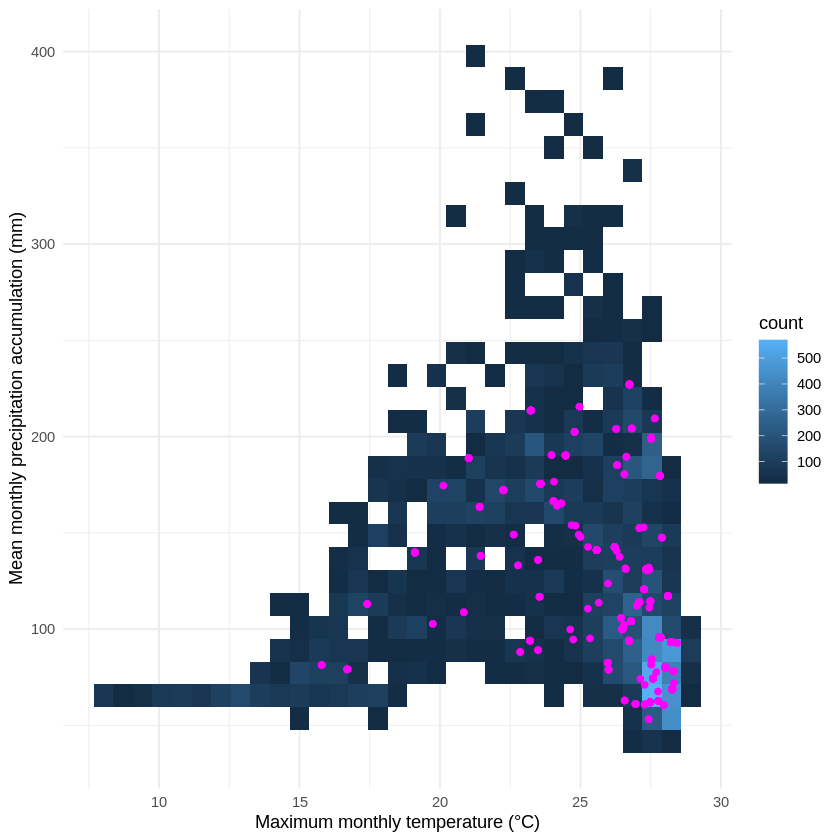

In [23]:
climate_dt %>%
  ggplot(aes(x=tmmx*0.1,y=pr))+
  geom_bin2d() +
  # geom_point(data=soilHealth_dt,aes(x=tmmx*0.1,y=pr),color= pial_none)+
  geom_point(data=soilHealth_dt,aes(x=tmmx*0.1,y=pr),color='magenta')+
  labs(x = "Maximum monthly temperature (°C)", y = "Mean monthly precipitation accumulation (mm)") +
  theme_minimal()

TB wants coordinates colored based on Land Use in one version and suborder in another

In [24]:
names(soilHealth_dt)

[1] "number"                              "depth_top"                          
 [3] "depth_bottom"                        "island"                             
 [5] "site_name"                           "site_number"                        
 [7] "current_land_use"                    "years_under_current_land_use"       
 [9] "most_previous_land_use"              "years_under_most_previous._land_use"
[11] "plot_name"                           "plot_area"                          
[13] "current_plant_cover"                 "previous_crop_cover"                
[15] "tillage"                             "tillage_frequency"                  
[17] "herbicide"                           "pesticide"                          
[19] "irrigation_type"                     "additional_soil_cover"              
[21] "soil_series"                         "management_category"                
[23] "pial_none"                           "distlevel"                          
[25] "order"                               "minerals"                           
[27] "swc_fm"                              "swc_ad"                             
[29] "toc"                                 "tn"                                 
[31] "co2_burst"                           "beta_glucosidase"                   
[33] "beta_glucosaminidase"                "pnm_init"                           
[35] "pmn_fin"                             "ph"                                 
[37] "doc"                                 "tdn"                                
[39] "din"                                 "don"                                
[41] "hwec"                                "hwen"                               
[43] "whc"                                 "wsa_mega"                           
[45] "wsa_macro"                           "bd"                                 
[47] "shs"                                 "assessment"                         
[49] "c_n"                                 "doc_don"                            
[51] "pmn"                                 "status"                             
[53] "hyperlinks"                          "last.updated"                       
[55] "SOC_stock"                           "SOC_stock_kg_m2"                    
[57] "SOC_stock_Mg_ha"                     "geom"                               
[59] "aet"                                 "def"                                
[61] "pdsi"                                "pet"                                
[63] "pr"                                  "ro"                                 
[65] "soil"                                "srad"                               
[67] "swe"                                 "tmmn"                               
[69] "tmmx"                                "vap"                                
[71] "vpd"                                 "vs"